In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from itertools import product
from scipy.stats import norm
from utils import tMCL
from utils import kl_eigenfunctions, generate_quantization_points, reconstruct_quantized_trajectories,generate_brownian_motion,plot_brownian_trajectories,plot_brownian_bridge_samples,generate_brownian_bridge_samples

In [58]:
def generate_brownian_bridge_samples(batch_size, nb_discretization_points, interval_length, a=0, b=1):
    """
    Génère des trajectoires complètes de pont brownien sur [0, 1] et extrait un sous-trajet par trajectoire, de longueur fixe.

    :param batch_size: Nombre de sous-trajets à générer
    :param nb_discretization_points: Nombre total de points de discrétisation sur l'intervalle [0, 1]
    :param interval_length: Nombre de points dans chaque sous-trajet (bouts)
    :param a: Valeur initiale du pont brownien à t=0
    :param b: Valeur finale du pont brownien à t=1
    :return:
        - Tenseur de dimension (batch_size, interval_length, 1) contenant les sous-trajets
        - Tenseur de dimension (batch_size, 2) contenant les intervalles temporels [t0, t1] pour chaque sous-trajet
    """
    if interval_length > nb_discretization_points:
        raise ValueError("`interval_length` doit être inférieur ou égal à `nb_discretization_points`.")
    
    samples = []
    time_intervals = []

    for _ in range(batch_size):
        # Discrétisation de l'intervalle de temps
        t_full = np.linspace(0, 1, nb_discretization_points)
        dt = 1 / (nb_discretization_points - 1)

        # Génération d'un mouvement brownien standard (sans contrainte aux bornes)
        increments = np.random.normal(0, np.sqrt(dt), size=nb_discretization_points - 1)
        W = np.concatenate([[0], np.cumsum(increments)])

        # Correction pour obtenir un pont brownien : W(t) - correction linéaire
        bridge = a + W - t_full * (W[-1] - b + a)

        # Assurer que la contrainte est respectée (précision numérique)
        bridge[0] = a
        bridge[-1] = b

        # Sélection d'un sous-trajet aléatoire
        start_idx = np.random.randint(0, nb_discretization_points - interval_length+1 )
        end_idx = start_idx + interval_length

        sample = bridge[start_idx:end_idx]
        t0, t1 = t_full[start_idx], t_full[end_idx - 1]

        samples.append(sample.reshape(-1, 1))
        time_intervals.append([t0, t1])

    # Conversion en tenseurs PyTorch
    samples_tensor = torch.tensor(np.stack(samples), dtype=torch.float32)
    time_intervals_tensor = torch.tensor(np.stack(time_intervals), dtype=torch.float32)

    return samples_tensor, time_intervals_tensor

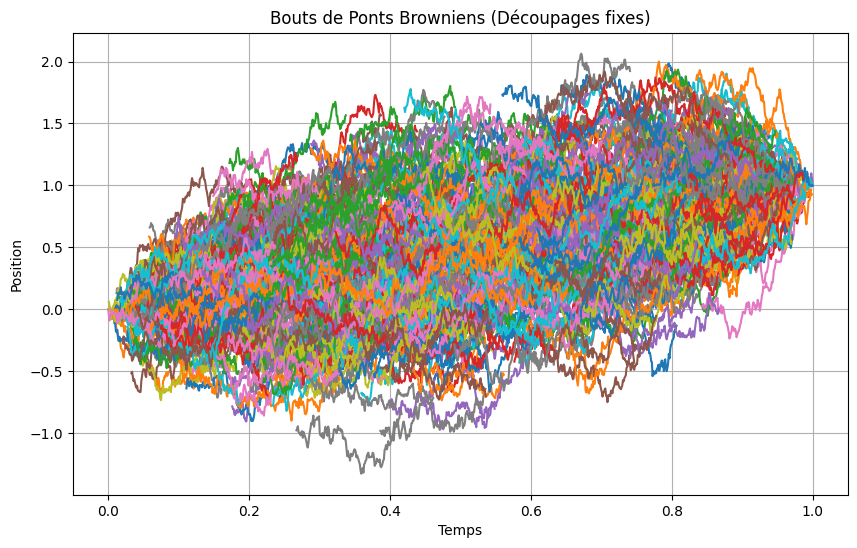

In [65]:
# Paramètres
batch_size = 1000
nb_discretization_points = 1000  # Résolution totale sur [0, 1]
interval_length = 150  # Nombre de points dans chaque sous-trajet
a, b = 0, 1  # Valeurs initiale et finale du pont brownien

# Génération des échantillons
samples, time_intervals = generate_brownian_bridge_samples(
    batch_size=batch_size,
    nb_discretization_points=nb_discretization_points,
    interval_length=interval_length,
    a=a,
    b=b
)

# Affichage des sous-trajets
plot_brownian_bridge_samples(samples, time_intervals)

In [67]:
def train_tMCL_for_bridge(
    model, 
    num_epochs, 
    batch_size, 
    nb_discretization_points, 
    interval_length,
    device, 
    learning_rate=0.001
):
    """
    Entraîne le réseau de neurones tMCL avec des bouts de trajectoires browniennes.

    :param model: Instance du modèle tMCL
    :param num_epochs: Nombre d'époques d'entraînement
    :param batch_size: Taille du batch pour la génération de trajectoires
    :param nb_step_simulation: Longueur des trajectoires simulées (bouts)
    :param nb_timesteps_discretisation: Nombre total de points de discrétisation sur [0, 1]
    :param interval_length: Longueur de chaque bout en nombre de points
    :param device: Dispositif d'exécution (CPU ou GPU)
    :param learning_rate: Taux d'apprentissage
    :return: Modèle entraîné
    """
    import torch.optim as optim

    # Définir l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Basculer le modèle en mode entraînement
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        # Générer un batch de bouts de trajectoires browniennes
        trajectories, time_intervals = generate_brownian_bridge_samples(
            batch_size=batch_size,
            nb_discretization_points=nb_discretization_points,
            interval_length=interval_length,
            a=0,
            b=1
        )
        trajectories = trajectories.to(device)
        time_intervals = time_intervals.to(device)

        # Extraire t0 pour l'état caché
        t0 = time_intervals[:, 0].unsqueeze(-1)  # [batch_size, 1]

        # Ajouter t0 en tant qu'entrée cachée
        distr_args = torch.cat([trajectories[:, 0, :], t0], dim=-1)  # [batch_size, cond_dim]

        # Les cibles : target_list (les trajectoires complètes)
        target_list = trajectories[:, :, :]  # [batch_size, nb_step_simulation, 1]

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les prédictions et la perte
        loss = model.log_prob(target_list, distr_args)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Afficher les progrès
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

In [98]:
# Définir les paramètres
batch_size = 15000
nb_discretization_points = 500 #300 before

interval_length = 250  # La longueur des bouts correspond à la taille des simulations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = tMCL(
    cond_dim=2,  # 1 pour la valeur de départ + 1 pour t0
    nb_step_simulation=interval_length,
    n_hypotheses=10,
    device=device,
    loss_type="wta"  # Utilisation de la perte WTA
)

# Lancer l'entraînement
trained_model = train_tMCL_for_bridge(
    model=model,
    num_epochs=250,
    batch_size=batch_size,
    nb_discretization_points=nb_discretization_points,
    interval_length=interval_length,
    device=device,
    learning_rate=0.001
)

Epoch [10/250], Loss: 33.3019
Epoch [20/250], Loss: 15.1461
Epoch [30/250], Loss: 12.6153
Epoch [40/250], Loss: 10.9866
Epoch [50/250], Loss: 10.2450
Epoch [60/250], Loss: 9.9636
Epoch [70/250], Loss: 9.9351
Epoch [80/250], Loss: 9.6524
Epoch [90/250], Loss: 9.6500
Epoch [100/250], Loss: 9.5415
Epoch [110/250], Loss: 9.5645
Epoch [120/250], Loss: 9.4119
Epoch [130/250], Loss: 9.4765
Epoch [140/250], Loss: 9.4427
Epoch [150/250], Loss: 9.4248
Epoch [160/250], Loss: 9.5228
Epoch [170/250], Loss: 9.4133
Epoch [180/250], Loss: 9.4674
Epoch [190/250], Loss: 9.4374
Epoch [200/250], Loss: 9.4153
Epoch [210/250], Loss: 9.4022
Epoch [220/250], Loss: 9.3995
Epoch [230/250], Loss: 9.3284
Epoch [240/250], Loss: 9.3523
Epoch [250/250], Loss: 9.3145


In [99]:

# Définir les fonctions propres de Karhunen-Loève pour le pont brownien
def kl_eigenfunctions(t, T, m):
    """
    Calcule les m premières fonctions propres et valeurs propres pour le pont brownien.
    :param t: Points de discrétisation sur l'intervalle [0, T]
    :param T: Longueur totale de l'intervalle [0, T]
    :param m: Nombre de fonctions propres et valeurs propres à calculer
    :return: Liste des fonctions propres et des valeurs propres
    """
    eigenfunctions = []
    eigenvalues = []
    for n in range(1, m + 1):
        # Fonction propre e_n(t)
        eigenfunc = np.sqrt(2 / T) * np.sin(np.pi * n * t / T)
        # Valeur propre lambda_n
        eigenval = (T / (n * np.pi))**2
        eigenfunctions.append(eigenfunc)
        eigenvalues.append(eigenval)
    return np.array(eigenfunctions), np.array(eigenvalues)

# Générer les points de quantification optimaux pour une loi normale
def generate_quantization_points(N, dist_mean=0, dist_var=1):
    """
    Génère les points optimaux pour quantifier une loi normale centrée.
    """
    std_dev = np.sqrt(dist_var)
    return norm.ppf(np.linspace(1 / (2 * N), 1 - 1 / (2 * N), N)) * std_dev

# Reconstruire les trajectoires quantifiées pour un pont brownien conditionné
def reconstruct_quantized_trajectories_conditioned(N_levels, eigenfunctions, eigenvalues, t, x, b):
    """
    Reconstruit les trajectoires quantifiées pour un pont brownien conditionné qui commence en x à t et termine en b à T.
    :param N_levels: Liste des niveaux de quantification par dimension [N1, N2, ..., Nm]
    :param eigenfunctions: Liste des fonctions propres
    :param eigenvalues: Liste des valeurs propres
    :param t: Points de discrétisation sur l'intervalle [t, T]
    :param x: Valeur initiale du pont à t
    :param b: Valeur finale du pont à T
    """
    m = len(N_levels)
    quantization_grids = [generate_quantization_points(N, dist_var=1) for N in N_levels]
    multi_indices = list(product(*[range(len(grid)) for grid in quantization_grids]))
    
    # Interpolation linéaire pour conditions aux bords
    linear_interpolation = (1 - (t - t[0]) / (t[-1] - t[0])) * x + ((t - t[0]) / (t[-1] - t[0])) * b
    
    trajectories = []
    for index in multi_indices:
        # Calcul des trajectoires quantifiées
        trajectory = sum(
            np.sqrt(eigenvalues[n]) * quantization_grids[n][index[n]] * eigenfunctions[n]
            for n in range(m)
        )
        # Ajouter l'interpolation linéaire
        trajectories.append(trajectory + linear_interpolation)
    
    return np.array(trajectories)

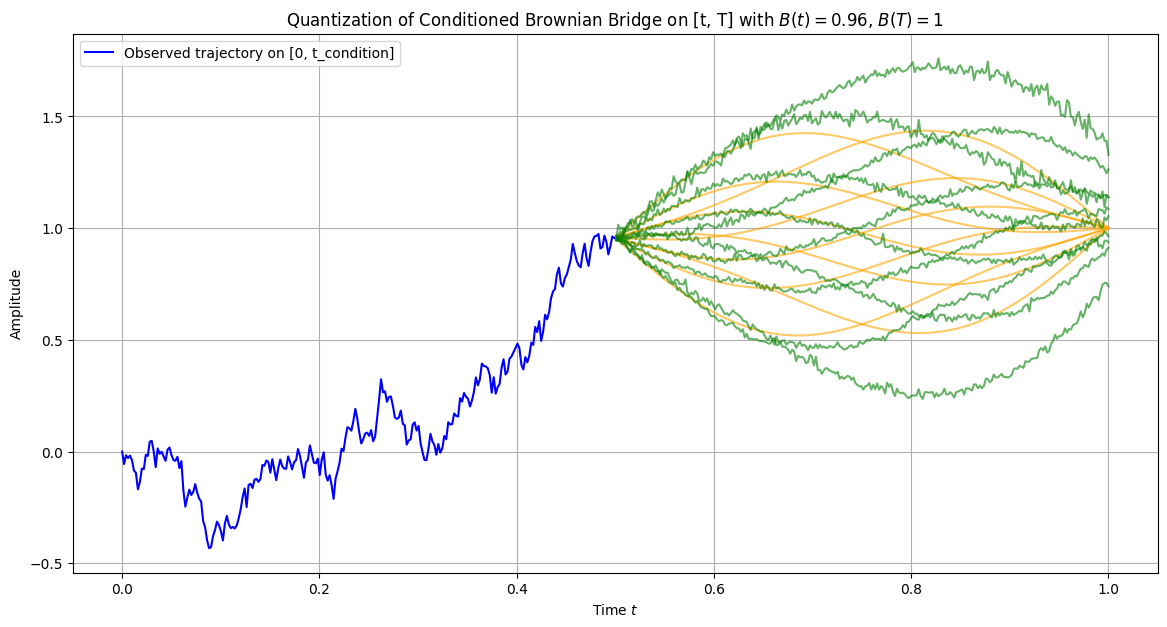

In [111]:
t_condition = 0.5  # Point de conditionnement
T = t_condition + interval_length/nb_discretization_points
num_steps = nb_discretization_points     # Nombre de points dans l'intervalle
m = 2               # Nombre de dimensions utilisées (troncature)
N_levels = [5, 2]   # Niveaux de quantification par dimension
a = 0             # Valeur initiale du pont brownien
b = 1          # Valeur finale du pont brownien

# Discrétisation de l'intervalle [0, T]
t_full = np.linspace(0, T, num_steps)

dt = T / len(t_full)  # Pas de temps
W = np.cumsum(np.sqrt(dt) * np.random.randn(len(t_full)))  # Mouvement brownien
W = np.insert(W, 0, 0)[:-1] 
bridge_0_T = W - (t_full / T) * W[-1] + (1 - t_full / T) * a + (t_full / T) * b

t_observed = t_full[t_full <= t_condition]
bridge_0_t = bridge_0_T[:len(t_observed)]

B_t = bridge_0_t[-1] #last observed value in t_observed

# for the quantization -- theorical values 
t_quantized = t_full[t_full >= t_condition]
eigenfunctions, eigenvalues = kl_eigenfunctions(t_quantized - t_condition, T - t_condition, m)

trajectories_quantized = reconstruct_quantized_trajectories_conditioned(
    N_levels, eigenfunctions, eigenvalues, t_quantized, B_t, b
)



predictions_neural = trained_model.forward(torch.tensor([[ float(B_t),t_condition]]))[0].detach().numpy()


# Visualisation
plt.figure(figsize=(14, 7))

plt.plot(t_observed, bridge_0_t, label="Observed trajectory on [0, t_condition]", color='blue')

for trajectory in trajectories_quantized:
    plt.plot(t_quantized[:len(predictions_neural[0])], trajectory[:len(predictions_neural[0])], alpha=0.6, color='orange')


for trajectory in predictions_neural:
    plt.plot(t_quantized[:len(predictions_neural[0])], trajectory, alpha=0.6, color='green')

plt.title(f"Quantization of Conditioned Brownian Bridge on [t, T] with $B(t)={B_t:.2f}$, $B(T)={b}$")
plt.xlabel("Time $t$")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [114]:
predictions_neural[:,-1]

array([0.74031335, 1.054225  , 1.1376739 , 1.139019  , 0.9378698 ,
       1.3282007 , 1.2631278 , 1.0854292 , 0.9632458 , 0.9117446 ],
      dtype=float32)

In [ ]:
predictions_neural